In [158]:
import json
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Index
* [Load data](#Load-data)
* [Count time zones](#Count-time-zones)
* [Count browsers](#Count-browsers)

### Load data

In [159]:
path = "../data/usagov_bitly_data2012-03-16-1331923249.txt"

In [160]:
records = []
with open(path,"rt") as infile:
    for index,row in enumerate(infile):
        try:
            records.append(json.loads(row))
            logging.info("%d-th row is successfully parsed",index+1)
        except Exception as ex:
            print "!!! failed to parse %d-th row: %s"%(index+1,row)

!!! failed to parse 3407-th row: { "a": "Mozilla\/0.6 Beta (Windows)", "c": "PL", "nk": 0, "tz": "Europe\/Warsaw", "gr": "86", "g": "hT2sKJ", "h": "iaVuBv", "l": "twitterfeed", "hh": "1.usa.gov", "r": "http:\/\/1.usa.gov\/iaVuBv", "u": "http:\/\/www.stripes.com\/news\/58-b


In [161]:
df = pd.DataFrame(records)

### Count time zones

In [162]:
timezones = df["tz"]# it's a view

In [163]:
print "{} records has no time-zones".format(timezones.isnull().sum())
print "{} records has empty time-zones".format((timezones == '').sum())

113 records has no time-zones
490 records has empty time-zones


In [164]:
clean_timezones = timezones.fillna("!!! Missing !!!")# get a copy
clean_timezones[ clean_timezones == "" ] = "!!! Empty !!!"

In [165]:
tz_counts = clean_timezones.value_counts()# by default, value_counts() won't consider NA
tz_counts[:10]# already sorted

America/New_York       1211
!!! Empty !!!           490
America/Chicago         376
America/Los_Angeles     368
America/Denver          179
!!! Missing !!!         113
Europe/London            72
Asia/Tokyo               37
Pacific/Honolulu         35
Europe/Madrid            34
Name: tz, dtype: int64

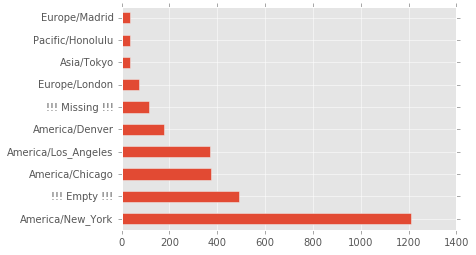

In [166]:
tz_counts[:10].plot(kind="barh")

### Count browsers

In [167]:
browsers = df["a"]# a view
print "{} records has no browsers".format(browsers.isnull().sum())
print "{} records has empty browsers".format((browsers == '').sum())

113 records has no browsers
0 records has empty browsers


In [168]:
# use another strategy to handle the missing values: just drop them
valid_browsers = browsers.dropna().map(lambda a: a.split()[0])

In [169]:
browser_counts = valid_browsers.value_counts()

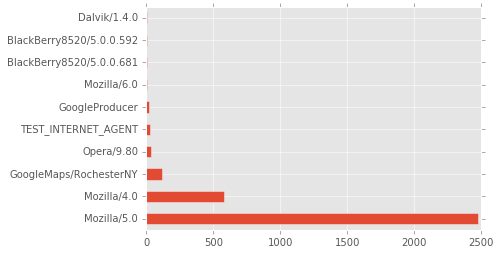

In [170]:
browser_counts[:10].plot(kind="barh")

### Group by Time zones and OS

In [171]:
print "original whole data: "
print "{} records has no time-zones".format(df.tz.isnull().sum())
print "{} records has empty time-zones".format((df.tz == '').sum())

original whole data: 
113 records has no time-zones
490 records has empty time-zones


In [172]:
clean_df =  df.loc[ df.a.notnull(),:]# clean_df is a copy of df

In [173]:
print "after filtering out missing agents: "
print "{} records has no time-zones".format(clean_df.tz.isnull().sum())
print "{} records has empty time-zones".format((clean_df.tz == '').sum())

after filtering out missing agents: 
0 records has no time-zones
490 records has empty time-zones


In [174]:
clean_df["tz"].fillna("!!! Missing !!!",inplace=True)
clean_df.loc[ clean_df.tz == "",:] = "!!! Empty !!!"

In [175]:
is_windows = np.where(clean_df.a.str.contains("Windows"),"Windows","Nonwindows")

In [176]:
grps_tz_os = clean_df.groupby(["tz",is_windows])

In [177]:
grpsize_tz_os = grps_tz_os.size().unstack().fillna(0).astype(np.int)
grpsize_tz_os.head()

,Nonwindows,Windows
tz,,
!!! Empty !!!,490,0
Africa/Cairo,0,3
Africa/Casablanca,0,1
Africa/Ceuta,0,2
Africa/Johannesburg,0,1


In [178]:
grpsize_tz_os["Total"] = grpsize_tz_os.sum(axis=1)

In [179]:
grpsize_tz_os.sort_values(by="Total",inplace=True,ascending=False)
grpsize_tz_os.head()

,Nonwindows,Windows,Total
tz,,,
America/New_York,330,881,1211
!!! Empty !!!,490,0,490
America/Chicago,107,269,376
America/Los_Angeles,123,245,368
America/Denver,125,54,179


In [180]:
top_grpsizes = grpsize_tz_os[:10].loc[:,["Nonwindows","Windows"]]
top_grpsizes

,Nonwindows,Windows
tz,,
America/New_York,330,881
!!! Empty !!!,490,0
America/Chicago,107,269
America/Los_Angeles,123,245
America/Denver,125,54
Europe/London,41,31
Asia/Tokyo,2,35
Pacific/Honolulu,0,35
Europe/Madrid,15,19


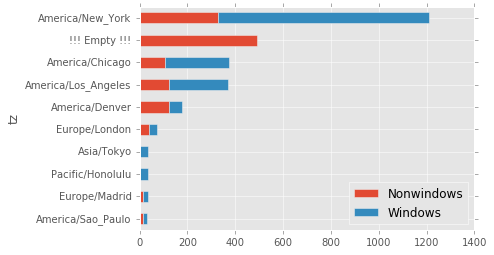

In [181]:
ax = top_grpsizes.plot(kind="barh",stacked=True)
ax.invert_yaxis()

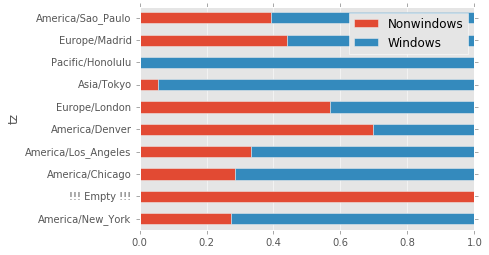

In [182]:
normed_top_grpsizes = top_grpsizes.div(top_grpsizes.sum(axis=1),axis=0)
normed_top_grpsizes.plot(kind="barh",stacked=True)